In [2]:
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import random as rnd
import itertools

%matplotlib inline

In [3]:
def drawGz(G,z,c):
    # DO NOT MODIFY THIS FUNCTION
    # This function draws G with node labels from partition z
    #
    # input  : G is a networkx graph
    #        : z is a dictionary of group labels for G's nodes
    #        : c is number of groups in z
    # output : none
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted
    seed=328
    rnd.seed(seed)

    # colors = ['#d61111','#11c6d6','#d67711','#11d646','#1b11d6','#d611cc'] # map node labels to colors (for the visualization)
        
    colors=[]
    
    for i in range(c):
        color='#%06x'%rnd.randint(0,0xFFFFFF) #pick 29 colors
        for col in colors:
            if col==color:
                color='#%06x'%rnd.randint(0,0xFFFFFF) #try to keep colors unique
        colors.append(color)


    node_colors = []
    for i in G.nodes():
        node_colors.append(colors[int(z[i])])
    nsize  = 600
    flabel = True
    

    if G.order() > 50:
        nsize  = 100
        flabel = False
        
    nx.draw_networkx(G,with_labels=flabel,node_size=nsize,width=1,node_color=node_colors) # draw it pretty
    limits=plt.axis('off')                                      # turn off axes
    plt.show() 

    return

In [4]:
def tabulate_wk(G,z,c):
    # This function tabulates the w_rs and kappa_r auxiliary data structures for the DC-SBM
    #
    # input  : G is simple graph with n nodes
    #        : z is a dictionary of group labels for G's nodes, into c groups
    #        : c is scalar, number of possible groups
    # output : wrs, kpr
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted
    
    wrs = np.zeros([c,c],dtype=int) # count of stubs from group r to group s
    kpr = np.zeros([c,1],dtype=int) # total degree of group r

    ##### do not modify above here #####

    
    ### YOUR CODE
    
    for e in list(G.edges()):
        for c1 in range(c):
            for c2 in range(c): #iterate through row and column of table
                # print(e)  #prints for debugging
                # print(z[e[0]])
                # print(z[e[1]])
                # print(c1)
                # print(c2)
                if (z[e[0]]==c1 and z[e[1]]==c2): #u to v edge found
                    wrs[c1][c2]+=1
                if (z[e[1]]==c1 and z[e[0]]==c2): #v to u edge found
                    wrs[c1][c2]+=1
                
                # print(wrs)
            kpr[c1][0]=sum(wrs[c1][:]) #kpr is sum of row r
                    
                
        
    ##### do not modify below here #####

    return wrs,kpr

In [5]:
def random_z(nmin,nmax,c):
    # input  : number of nodes n, and number of groups c
    # output : returns a random partition in a dictionary z, where z_i = Uniform(0,c-1)

    import random as rnd
    rnd.seed()
    
    z = dict()

    ##### do not modify above here #####

    
    ### YOUR CODE
    
    for i in range(nmin,nmax):
        r=rnd.randint(0,c-1)
        z[i]=r
    

    ##### do not modify below here #####

    return z

In [6]:
def dcsbm_LogL(wrs,kpr):
    # DO NOT MODIFY THIS FUNCTION
    # This function calculates the log-likelihood of the degree-corrected stochastic block model (DC-SBM)
    # See Eq. (9) in Lecture 6.
    #
    # input  : wrs is a c x c np.array of stub counts
    #        : kpr is a c x 1 np.array of stub counts 
    # output : the dcsbm log-likelihood
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

    c = wrs.shape[1]  # number of groups
    
    logL = 0
    for r in range(c):
        for s in range(c):
            if wrs[r,s] < 1 or kpr[r] < 1 or kpr[s] < 1:
                temp = 0 # define 0^0 = 1
            else:
                temp = wrs[r,s]*np.log( wrs[r,s] / (kpr[r]*kpr[s]) )
            logL = logL + temp
    
    return logL
    # DO NOT MODIFY THIS FUNCTION


In [7]:
def plotLL(LL,pc,n):
    # DO NOT MODIFY THIS FUNCTION
    # This function makes a nice plot of the log-likelihood trajectory
    #
    # input  : LL is list of log-likelihood values of length (n+1)*(pc+1)
    #        : n, number of nodes
    #        : pc, number of phases in LL
    # output : none
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

    tc  = len(LL)               # number of partitions considered in the LL trajectory

    fig = plt.figure()
    ax1 = fig.add_subplot(111) # put multiple 
    
    plt.plot(range(tc), LL, 'b.-', alpha=0.5)  # plot the log-likelihood trajectory
    for i in range(pc):                        # add vertical bars to demarcate phases, add black squares for phase-maxima
        plt.plot([(i)*(n+1),(i)*(n+1)],[min(LL),max(LL)], 'k--', alpha=0.5) # vertical bar
        LLp = LL[(i)*(n+1):(i+1)*(n+1)]
        b = LLp.index(max(LLp))
        plt.plot([(i)*(n+1)+b],[max(LLp)], 'ks', alpha=0.5)

    plt.ylabel('log-likelihood, DC-SBM')
    plt.xlabel('number of partitions considered')
    plt.show()

In [8]:
def makeAMove(G,z,c,f):
    # For each non 'frozen' node in the current partition, this function tries all (c-1) possible group moves for it
    # It returns the combination of [node i and new group r] that produces the best log-likelihood over the non-frozen set
    # input  : G, a graph
    #        : z, a partition of G's nodes
    #        : c, the number of groups
    #        : f, a binary labeling of frozen nodes
    #        : l, list of possible groups
    # output : bestL, the best log-likelihood found
    #        : bestMove, [i,r] the node i and new group r to achieve bestL
    
    bestL = -np.inf            # the best log-likelihood over all considered moves
    for i in G.nodes():        # loop over all nodes i
        if f[i] == 0:          # if i is not frozen
            s = int(z[i])      #  get current label of i
            for r in range(c): #  then loop over all groups r
                #print(f'v[{i}] s = {s}, r={r}, {r!=s}') # for debugging
                
                ##### do not modify above here #####

                
                ## YOUR CODE
                if r != s: # don't care about original group
                    z[i]=r #change group of node
                    wrs,kpr=tabulate_wk(G,z,c)
                    thisL=dcsbm_LogL(wrs,kpr)
                    # print(f'v[{i}] g[{int(s)} --> g[{r}] : {thisL}')
                    if(thisL > bestL): #new model is better than old model
                        bestL=thisL
                        bestMove=[i,r]
                z[i]=s #return to original group
                
                
                
                ##### do not modify below here #####    
                
    return bestL,bestMove

In [9]:
def run_OnePhase(G,z0,c,nmin,nmax):
    # Runs one phase, initialized from partition z0
    # Returns the best partition found in the phase and the list of LogL values for all the phase's partitions
    # input  : G, a graph
    #        : z0, initial partition of G's nodes
    #        : c, the number of groups
    # output : zstar, the best partition of the phase
    #        : Lstar, the LogL of zstar
    #        : LL, the inorder list of LogL values for the n+1 partitions of this phase
    #        : halt, 1 if zstar=z0 (no better partition found)

    import copy      # for copy.deepcopy() function
    n    = G.order() # n, number of nodes
    LL   = []        # stores log-likelihoods over the entire algorithm (via .append)
    halt = 0         # flag: =0 if Lstar > L0 at the end of the phase; =1 if Lstar <= L0

    # initialize the phase
    wrs,kpr = tabulate_wk(G,z0,c)      # wrs, kpr, initial DC-SBM parameters
    L0      = dcsbm_LogL(wrs,kpr)      # store initial DC-SBM log-likelihood
    LL.append(L0)                      # track log-likelihood

    f     = dict.fromkeys(range(nmin,nmax), 0) # initially, all nodes unfrozen (tricky python)
    t     = 0                          # number of frozen nodes in this phase
    Lstar = L0                         # initially, z0 has the best LogL
    zstar = copy.deepcopy(z0)          # and z0 is the best partition
    tstar = t                          # tstar = 0
    
    

    # loop over all the nodes in G, making greedy move for each
    zt = copy.deepcopy(z0)             # start the loop at z0
    for j in range(n):
        # print(f'step {j}') # for debugging

        ##### do not modify above here #####

        
        ### YOUR CODE
        LMove,Move=makeAMove(G,zt,c,f)
        t+=1
        LL.append(LMove) #add log likelyhood to list
        f[Move[0]]=1 #freeze
        if(LMove > Lstar): #new move has highest score
            Lstar=LMove #update new score
            zt[Move[0]]=Move[1] #change group of best node
            zstar=copy.deepcopy(zt) #save copy of new zt
            tstar=t #update which number partition is best
            # print(f't={tstar}: new log likelyhood {Lstar} by node {Move[0]} --> group {Move[1]}')
            
            
    if(tstar==0):
        halt=1 #convergence condition met
        
            


        ##### do not modify below here #####

    return zstar,Lstar,LL,halt

In [48]:
def fit_DCSBM(G,c,T,nmin,nmax):
    # Runs the full locally greedy heuristic, with c groups
    # Returns the best partition found, its LogL, and the list of LogL values for all partitions considered
    # input  : G, a graph
    #        : c, the number of groups
    #        : T, the number maximum number of phases allowed
    # output : zstar, the best partition of all of the phases
    #        : Lstar, the LogL of zstar
    #        : LL, the inorder list of all LogL values considered
    #        : pc, the number of phases in LL

    import copy # for copy.deepcopy()
    
    
    # 1.0 locally greedy heuristic setup
    n  = G.order() # n, number of nodes
    LL   = []      # log-likelihoods over the entire algorithm (concat via .extend)
    halt = 0       # convergence flag

    # 2.0 generate initial partition, calculate wrs,kpr, and store the loglikelihood in Lt
    zt      = random_z(nmin,nmax,c)       # z0, initial partition
    wrs,kpr = tabulate_wk(G,zt,c) # wrs, kpr, initial DC-SBM parameters
    Lt      = dcsbm_LogL(wrs,kpr) # store initial DC-SBM log-likelihood

    # 3.0 the main loop
    pc = 0  # counter for number of phases completed
    while not halt:
        # 3.1 visualization of this phase's initial partition
        print(f'phase[{pc}] z[0], logL = {Lt}')
        drawGz(G,zt,c) #commented out to reduce workload on algorithm

        ##### do not modify above here #####

        
        ### YOUR CODE
            
        
        zstar,Lstar,LLt,halt=run_OnePhase(G,zt,c,nmin,nmax)
        
        if(Lstar > Lt): #new best log likelyhood found
            zt=zstar # update best partition
            Lt=Lstar #update best log likelyhood
        
        LL.extend(LLt) # add new log likelyhoods to list
        
        if(pc ==T): #max amount of phases reached, return from function
            return zstar,Lstar,LL,pc
        pc+=1 #increment phase


        ##### do not modify below here #####
    
    print(f' --> WE HAVE CONVERGENCE <-- ') # a friendly alert
    return zstar,Lstar,LL,pc

In [11]:
def fit_DCSBM_reps(G,c,T,nmin,nmax,reps):
    BestL=-np.inf
    for r in range(reps):
        print(f'rep #{r+1}')
        zstar,Lstar,LL,pc = fit_DCSBM(G,c,T,nmin,nmax)
        if(Lstar > BestL): #new best log likelyhood found (should occur at least once since BestL starts at -inf)
            BestL=Lstar #copy over all values
            Bestz=zstar
            BestLL=LL
            Bestpc=pc
            Bestrep=r+1 
            

    return Bestz,BestL,BestLL,Bestpc,Bestrep
    
    
    
    
    

In [50]:
fname1='virus_virus_network.txt'
fname2='virus_family_metadata'


# read in the network file (an edge list)
print(f'reading the network file  : {fname1}')
G = nx.read_edgelist('./' + fname1, delimiter=', ', nodetype=int)  # import simple graph, index nodes by integers (not strings)

#add nodes without edges(we know that there are 586 nodes total)
nodes_missing=list()
for i in range(1,586):
    x=True
    for j in nx.nodes(G):
        if(i==j):
            x=False
    if x==True:
        nodes_missing.append(i)
        

        
G.add_nodes_from(nodes_missing)

# read in the node metadata (note: there are more metadata values here than nodes in G)
print(f'reading the metadata file : {fname2}\n')
f = open('./' + fname2,'r')
labels = []
for line in f:
    
    labels.append(line.split(',')[1].rstrip('\n')) # remove the index name for the metadata and strip the \n

s=set()
for i in range(0,len(labels)):
    s.add(labels[i]) #find each unique label
    

# for each node i in G, add (j: j's label) to a dictionary z

# print(labels)
z = {}
for i in range(1,len(labels)+1):
    z[i] = labels[i-1] 
        





    
    
n=G.order()
m=G.size()
kmean=2*m/n

print(f'number of nodes, n  = {n}')
print(f'number of edges, m  = {m}')
print(f'mean degree,    <k> = %5.2f' % kmean)



c=len(s)


##settings to create subgraph for analysis
nmin=350
nmax=380

G2=nx.subgraph(G,range(nmin,nmax))

z2={i:z[i] for i in range(nmin,nmax)}

print(z2)

s2=set()
for i in z2.keys():
    s2.add(z2[i])

    
slist=list(s2)

zints={}
for i in range(len(slist)):
    for j in z2.keys():
        if z2[j]==slist[i]:
            zints[j]=i
    

c2=len(s2)

n=G2.order()
m=G2.size()
kmean=2*m/n

print('Subgraph:')
print(f'number of nodes, n  = {n}')
print(f'number of edges, m  = {m}')
print(f'mean degree,    <k> = %5.2f' % kmean)
print(z2)
print(c2)

# drawGz(G2,zints,c2)

print(zints)

        


reading the network file  : virus_virus_network.txt
reading the metadata file : virus_family_metadata

number of nodes, n  = 586
number of edges, m  = 42475
mean degree,    <k> = 144.97
{350: 'Flaviviridae', 351: 'Rhabdoviridae', 352: 'Poxviridae', 353: 'Retroviridae', 354: 'Poxviridae', 355: 'Flaviviridae', 356: 'Arenaviridae', 357: 'Togaviridae', 358: 'Rhabdoviridae', 359: 'Retroviridae', 360: 'Parvoviridae', 361: 'Togaviridae', 362: 'Bunyaviridae', 363: 'Paramyxoviridae', 364: 'Herpesviridae', 365: 'Herpesviridae', 366: 'Herpesviridae', 367: 'Herpesviridae', 368: 'Herpesviridae', 369: 'Adenoviridae', 370: 'Adenoviridae', 371: 'Coronaviridae', 372: 'Retroviridae', 373: 'Caliciviridae', 374: 'Paramyxoviridae', 375: 'Polyomaviridae', 376: 'Polyomaviridae', 377: 'Flaviviridae', 378: 'Herpesviridae', 379: 'Poxviridae'}
Subgraph:
number of nodes, n  = 30
number of edges, m  = 128
mean degree,    <k> =  8.53
{350: 'Flaviviridae', 351: 'Rhabdoviridae', 352: 'Poxviridae', 353: 'Retroviridae'

In [43]:

T=10
reps=2

zstar,Lstar,LL,bestpc,bestrep=fit_DCSBM_reps(G2,c2,T,nmin,nmax,reps)


# for i in nx.nodes(G):
#     print(i)


rep #1
phase[0] z[0], logL = [-1395.35687375]
phase[1] z[0], logL = [-1278.02038267]
phase[2] z[0], logL = [-1275.77533496]
 --> WE HAVE CONVERGENCE <-- 
rep #2
phase[0] z[0], logL = [-1404.94005162]
phase[1] z[0], logL = [-1276.18085553]
phase[2] z[0], logL = [-1274.49437717]
 --> WE HAVE CONVERGENCE <-- 


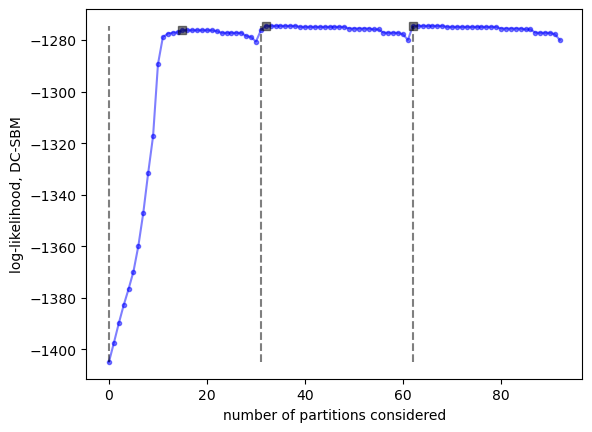

{350: 4, 351: 5, 352: 5, 353: 12, 354: 5, 355: 5, 356: 3, 357: 10, 358: 1, 359: 11, 360: 13, 361: 11, 362: 6, 363: 6, 364: 9, 365: 1, 366: 11, 367: 7, 368: 5, 369: 11, 370: 11, 371: 0, 372: 11, 373: 9, 374: 2, 375: 8, 376: 11, 377: 5, 378: 11, 379: 7}
{371: 'Caliciviridae', 358: 'Adenoviridae', 365: 'Adenoviridae', 374: 'Parvoviridae', 356: 'Herpesviridae', 350: 'Coronaviridae', 351: 'Paramyxoviridae', 352: 'Paramyxoviridae', 354: 'Paramyxoviridae', 355: 'Paramyxoviridae', 368: 'Paramyxoviridae', 377: 'Paramyxoviridae', 362: 'Arenaviridae', 363: 'Arenaviridae', 367: 'Polyomaviridae', 379: 'Polyomaviridae', 375: 'Retroviridae', 364: 'Rhabdoviridae', 373: 'Rhabdoviridae', 357: 'Togaviridae', 359: 'Poxviridae', 361: 'Poxviridae', 366: 'Poxviridae', 369: 'Poxviridae', 370: 'Poxviridae', 372: 'Poxviridae', 376: 'Poxviridae', 378: 'Poxviridae', 353: 'Bunyaviridae', 360: 'Flaviviridae'}


In [52]:
plotLL(LL,bestpc,G2.order())
print(zstar)


#convert int dict to string dict
zstr={}
for i in range(len(slist)):
    for j in zstar.keys():
        if zstar[j]==i:
            zstr[j]=slist[i]
            
print(zstr)